In [1]:
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-11-23 13:55:38.234390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2010'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(end_year), int(end_month), int(end_day))
t = numOfDays(date1, date2)+1

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)

cores = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*96,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*96)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in input data- TIR and historical core data at t<to
#core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
#ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
#cores = ds['msg_cores'].values# uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
#tir = ds['msg_Tir'].values/10000 # uint.interpolate_data(ds['tir'].values, inds, weights, shape)  # interpolation using saved weights for MSG TIR          
#time_core = ds['time']# (core_filename[-15:-3])


In [7]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
             
elif int(start_year)<int(end_year):
    y=1
    for i in range(int(start_year),int(end_year)+1,1):
        if y==1:
            for m in range(int(start_month),10,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
                y=y+1
                month=[]
            
        else:
            for m in range(1,int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)    
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
                    dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

11712


In [8]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010015.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010030.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010045.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010115.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010130.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010145.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010215.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010230.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010245.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010315.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010330.nc
14
/prj/

122
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020645.nc
123
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020700.nc
124
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020715.nc
125
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020730.nc
126
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020745.nc
127
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020800.nc
128
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020815.nc
129
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020830.nc
130
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020845.nc
131
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020900.nc
132
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020915.nc
133
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020930.nc
134
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006020945.nc
135
/prj/nflics/hist_cores/2010/06/02/Hist_cores_wa_201006021000.nc
136
/prj/nflics/hist_cores/2010/06/02/Hist_cores

243
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031300.nc
244
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031315.nc
245
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031330.nc
246
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031345.nc
247
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031400.nc
248
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031415.nc
249
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031430.nc
250
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031445.nc
251
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031500.nc
252
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031515.nc
253
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031530.nc
254
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031545.nc
255
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031600.nc
256
/prj/nflics/hist_cores/2010/06/03/Hist_cores_wa_201006031615.nc
257
/prj/nflics/hist_cores/2010/06/03/Hist_cores

365
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041930.nc
366
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006041945.nc
367
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042000.nc
368
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042015.nc
369
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042030.nc
370
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042045.nc
371
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042100.nc
372
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042115.nc
373
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042130.nc
374
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042145.nc
375
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042200.nc
376
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042215.nc
377
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042230.nc
378
/prj/nflics/hist_cores/2010/06/04/Hist_cores_wa_201006042245.nc
379
/prj/nflics/hist_cores/2010/06/04/Hist_cores

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060145.nc
487
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060200.nc
488
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060215.nc
489
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060230.nc
490
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060245.nc
491
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060300.nc
492
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060315.nc
493
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060330.nc
494
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060345.nc
495
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
496
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060415.nc
497
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060430.nc
498
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060445.nc
499
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
500
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070800.nc
608
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070815.nc
609
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070830.nc
610
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070845.nc
611
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070900.nc
612
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070915.nc
613
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070930.nc
614
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006070945.nc
615
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071000.nc
616
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071015.nc
617
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071030.nc
618
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071045.nc
619
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071100.nc
620
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_201006071115.nc
621
/prj/nflics/hist_cores/2010/06/07/Hist_cores_wa_

729
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081430.nc
730
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081445.nc
731
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081500.nc
732
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081515.nc
733
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081530.nc
734
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081545.nc
735
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081600.nc
736
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081615.nc
737
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081630.nc
738
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081645.nc
739
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081700.nc
740
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081715.nc
741
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081730.nc
742
/prj/nflics/hist_cores/2010/06/08/Hist_cores_wa_201006081745.nc
743
/prj/nflics/hist_cores/2010/06/08/Hist_cores

/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092045.nc
851
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092100.nc
852
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092115.nc
853
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092130.nc
854
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092145.nc
855
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092200.nc
856
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092215.nc
857
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092230.nc
858
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092245.nc
859
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092300.nc
860
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092315.nc
861
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092330.nc
862
/prj/nflics/hist_cores/2010/06/09/Hist_cores_wa_201006092345.nc
863
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_201006100000.nc
864
/prj/nflics/hist_cores/2010/06/10/Hist_cores_wa_

973
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110330.nc
974
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110345.nc
975
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110400.nc
976
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110415.nc
977
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110430.nc
978
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110445.nc
979
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110500.nc
980
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110515.nc
981
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110530.nc
982
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110545.nc
983
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
984
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110615.nc
985
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110630.nc
986
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110645.nc
987
/prj/nflics/hist_cores/2010/06/11/Hist_cores

1093
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120930.nc
1094
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006120945.nc
1095
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121000.nc
1096
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121015.nc
1097
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121030.nc
1098
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121045.nc
1099
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121100.nc
1100
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121115.nc
1101
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121130.nc
1102
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121145.nc
1103
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121200.nc
1104
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121215.nc
1105
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121230.nc
1106
/prj/nflics/hist_cores/2010/06/12/Hist_cores_wa_201006121245.nc
1107
/prj/nflics/hist_cores/2010/0

1212
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131515.nc
1213
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131530.nc
1214
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131545.nc
1215
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131600.nc
1216
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131615.nc
1217
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131630.nc
1218
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131645.nc
1219
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131700.nc
1220
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131715.nc
1221
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131730.nc
1222
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131745.nc
1223
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131800.nc
1224
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131815.nc
1225
/prj/nflics/hist_cores/2010/06/13/Hist_cores_wa_201006131830.nc
1226
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142100.nc
1332
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142115.nc
1333
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142130.nc
1334
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142145.nc
1335
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142200.nc
1336
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142215.nc
1337
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142230.nc
1338
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142245.nc
1339
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142300.nc
1340
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142315.nc
1341
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142330.nc
1342
/prj/nflics/hist_cores/2010/06/14/Hist_cores_wa_201006142345.nc
1343
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150000.nc
1344
/prj/nflics/hist_cores/2010/06/15/Hist_cores_wa_201006150015.nc
1345
/prj/nflics/hist_cores/2010/06/15/

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160300.nc
1452
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160315.nc
1453
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160330.nc
1454
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160345.nc
1455
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160400.nc
1456
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160415.nc
1457
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160430.nc
1458
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160445.nc
1459
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160500.nc
1460
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160515.nc
1461
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160530.nc
1462
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160545.nc
1463
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160600.nc
1464
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160615.nc
1465
/prj/nflics/hist_cores/2010/06/16/

1571
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170900.nc
1572
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170915.nc
1573
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170930.nc
1574
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006170945.nc
1575
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171000.nc
1576
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171015.nc
1577
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171030.nc
1578
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171045.nc
1579
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171100.nc
1580
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171115.nc
1581
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171130.nc
1582
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171145.nc
1583
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171200.nc
1584
/prj/nflics/hist_cores/2010/06/17/Hist_cores_wa_201006171215.nc
1585
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181445.nc
1691
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181500.nc
1692
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181515.nc
1693
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181530.nc
1694
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181545.nc
1695
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181600.nc
1696
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181615.nc
1697
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181630.nc
1698
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181645.nc
1699
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181700.nc
1700
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181715.nc
1701
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181730.nc
1702
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181745.nc
1703
/prj/nflics/hist_cores/2010/06/18/Hist_cores_wa_201006181800.nc
1704
/prj/nflics/hist_cores/2010/06/18/

/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192030.nc
1810
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192045.nc
1811
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192100.nc
1812
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192115.nc
1813
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192130.nc
1814
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192145.nc
1815
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192200.nc
1816
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192215.nc
1817
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192230.nc
1818
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192245.nc
1819
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192300.nc
1820
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192315.nc
1821
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192330.nc
1822
/prj/nflics/hist_cores/2010/06/19/Hist_cores_wa_201006192345.nc
1823
/prj/nflics/hist_cores/2010/06/20/

1928
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210215.nc
1929
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210230.nc
1930
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210245.nc
1931
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210300.nc
1932
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210315.nc
1933
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210330.nc
1934
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210345.nc
1935
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210400.nc
1936
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210415.nc
1937
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210430.nc
1938
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210445.nc
1939
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210500.nc
1940
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210515.nc
1941
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006210530.nc
1942
/prj/nflics/hist_cores/2010/0

2048
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220815.nc
2049
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220830.nc
2050
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220845.nc
2051
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220900.nc
2052
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220915.nc
2053
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220930.nc
2054
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006220945.nc
2055
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221000.nc
2056
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221015.nc
2057
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221030.nc
2058
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221045.nc
2059
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221100.nc
2060
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221115.nc
2061
/prj/nflics/hist_cores/2010/06/22/Hist_cores_wa_201006221130.nc
2062
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231415.nc
2169
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231430.nc
2170
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231445.nc
2171
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231500.nc
2172
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231515.nc
2173
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231530.nc
2174
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231545.nc
2175
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231600.nc
2176
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231615.nc
2177
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231630.nc
2178
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231645.nc
2179
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231700.nc
2180
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231715.nc
2181
/prj/nflics/hist_cores/2010/06/23/Hist_cores_wa_201006231730.nc
2182
/prj/nflics/hist_cores/2010/06/23/

2288
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242015.nc
2289
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242030.nc
2290
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242045.nc
2291
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242100.nc
2292
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242115.nc
2293
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242130.nc
2294
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242145.nc
2295
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242200.nc
2296
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242215.nc
2297
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242230.nc
2298
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242245.nc
2299
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242300.nc
2300
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242315.nc
2301
/prj/nflics/hist_cores/2010/06/24/Hist_cores_wa_201006242330.nc
2302
/prj/nflics/hist_cores/2010/0

2408
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260215.nc
2409
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260230.nc
2410
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260245.nc
2411
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260300.nc
2412
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260315.nc
2413
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260330.nc
2414
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260345.nc
2415
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260400.nc
2416
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260415.nc
2417
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260430.nc
2418
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260445.nc
2419
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260500.nc
2420
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260515.nc
2421
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006260530.nc
2422
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270815.nc
2529
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270830.nc
2530
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270845.nc
2531
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270900.nc
2532
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270915.nc
2533
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270930.nc
2534
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270945.nc
2535
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271000.nc
2536
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271015.nc
2537
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271030.nc
2538
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271045.nc
2539
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271100.nc
2540
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271115.nc
2541
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006271130.nc
2542
/prj/nflics/hist_cores/2010/06/27/

2648
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281415.nc
2649
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281430.nc
2650
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281445.nc
2651
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281500.nc
2652
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281515.nc
2653
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281530.nc
2654
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281545.nc
2655
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281600.nc
2656
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281615.nc
2657
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281630.nc
2658
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281645.nc
2659
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281700.nc
2660
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281715.nc
2661
/prj/nflics/hist_cores/2010/06/28/Hist_cores_wa_201006281730.nc
2662
/prj/nflics/hist_cores/2010/0

2768
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292015.nc
2769
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292030.nc
2770
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292045.nc
2771
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292100.nc
2772
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292115.nc
2773
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292130.nc
2774
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292145.nc
2775
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292200.nc
2776
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292215.nc
2777
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292230.nc
2778
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292245.nc
2779
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292300.nc
2780
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292315.nc
2781
/prj/nflics/hist_cores/2010/06/29/Hist_cores_wa_201006292330.nc
2782
/prj/nflics/hist_cores/2010/0

2887
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010200.nc
2888
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010215.nc
2889
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010230.nc
2890
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010245.nc
2891
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010300.nc
2892
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010315.nc
2893
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010330.nc
2894
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010345.nc
2895
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010400.nc
2896
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010415.nc
2897
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010430.nc
2898
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010445.nc
2899
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010500.nc
2900
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007010515.nc
2901
/prj/nflics/hist_cores/2010/0

3006
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020745.nc
3007
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020800.nc
3008
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020815.nc
3009
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020830.nc
3010
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020845.nc
3011
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020900.nc
3012
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020915.nc
3013
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020930.nc
3014
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020945.nc
3015
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021000.nc
3016
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021015.nc
3017
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021030.nc
3018
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021045.nc
3019
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007021100.nc
3020
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031330.nc
3126
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031345.nc
3127
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031400.nc
3128
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031415.nc
3129
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031430.nc
3130
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031445.nc
3131
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031500.nc
3132
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031515.nc
3133
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031530.nc
3134
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031545.nc
3135
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031600.nc
3136
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031615.nc
3137
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031630.nc
3138
/prj/nflics/hist_cores/2010/07/03/Hist_cores_wa_201007031645.nc
3139
/prj/nflics/hist_cores/2010/07/03/

3245
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041930.nc
3246
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007041945.nc
3247
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042000.nc
3248
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042015.nc
3249
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042030.nc
3250
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042045.nc
3251
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042100.nc
3252
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042115.nc
3253
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042130.nc
3254
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042145.nc
3255
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042200.nc
3256
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042215.nc
3257
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042230.nc
3258
/prj/nflics/hist_cores/2010/07/04/Hist_cores_wa_201007042245.nc
3259
/prj/nflics/hist_cores/2010/0

3365
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060130.nc
3366
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060145.nc
3367
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060200.nc
3368
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060215.nc
3369
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060230.nc
3370
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060245.nc
3371
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060300.nc
3372
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060315.nc
3373
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060330.nc
3374
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060345.nc
3375
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060400.nc
3376
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060415.nc
3377
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060430.nc
3378
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007060445.nc
3379
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070715.nc
3485
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070730.nc
3486
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070745.nc
3487
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070800.nc
3488
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070815.nc
3489
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070830.nc
3490
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070845.nc
3491
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070900.nc
3492
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070915.nc
3493
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070930.nc
3494
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070945.nc
3495
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071000.nc
3496
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071015.nc
3497
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007071030.nc
3498
/prj/nflics/hist_cores/2010/07/07/

3604
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081315.nc
3605
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081330.nc
3606
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081345.nc
3607
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081400.nc
3608
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081415.nc
3609
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081430.nc
3610
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081445.nc
3611
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081500.nc
3612
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081515.nc
3613
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081530.nc
3614
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081545.nc
3615
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081600.nc
3616
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081615.nc
3617
/prj/nflics/hist_cores/2010/07/08/Hist_cores_wa_201007081630.nc
3618
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091915.nc
3725
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091930.nc
3726
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007091945.nc
3727
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092000.nc
3728
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092015.nc
3729
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092030.nc
3730
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092045.nc
3731
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092100.nc
3732
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092115.nc
3733
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092130.nc
3734
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092145.nc
3735
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092200.nc
3736
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092215.nc
3737
/prj/nflics/hist_cores/2010/07/09/Hist_cores_wa_201007092230.nc
3738
/prj/nflics/hist_cores/2010/07/09/

/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110100.nc
3844
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110115.nc
3845
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110130.nc
3846
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110145.nc
3847
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110200.nc
3848
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110215.nc
3849
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110230.nc
3850
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110245.nc
3851
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110300.nc
3852
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110315.nc
3853
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110330.nc
3854
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110345.nc
3855
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110400.nc
3856
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007110415.nc
3857
/prj/nflics/hist_cores/2010/07/11/

3962
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120645.nc
3963
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120700.nc
3964
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120715.nc
3965
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120730.nc
3966
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120745.nc
3967
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120800.nc
3968
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120815.nc
3969
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120830.nc
3970
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120845.nc
3971
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120900.nc
3972
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120915.nc
3973
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120930.nc
3974
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120945.nc
3975
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007121000.nc
3976
/prj/nflics/hist_cores/2010/0

4083
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131300.nc
4084
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131315.nc
4085
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131330.nc
4086
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131345.nc
4087
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131400.nc
4088
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131415.nc
4089
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131430.nc
4090
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131445.nc
4091
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131500.nc
4092
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131515.nc
4093
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131530.nc
4094
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131545.nc
4095
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131600.nc
4096
/prj/nflics/hist_cores/2010/07/13/Hist_cores_wa_201007131615.nc
4097
/prj/nflics/hist_cores/2010/0

4202
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141845.nc
4203
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141900.nc
4204
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141915.nc
4205
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141930.nc
4206
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007141945.nc
4207
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142000.nc
4208
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142015.nc
4209
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142030.nc
4210
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142045.nc
4211
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142100.nc
4212
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142115.nc
4213
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142130.nc
4214
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142145.nc
4215
/prj/nflics/hist_cores/2010/07/14/Hist_cores_wa_201007142200.nc
4216
/prj/nflics/hist_cores/2010/0

4322
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160045.nc
4323
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160100.nc
4324
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160115.nc
4325
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160130.nc
4326
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160145.nc
4327
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160200.nc
4328
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160215.nc
4329
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160230.nc
4330
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160245.nc
4331
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160300.nc
4332
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160315.nc
4333
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160330.nc
4334
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160345.nc
4335
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007160400.nc
4336
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170645.nc
4443
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170700.nc
4444
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170715.nc
4445
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170730.nc
4446
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170745.nc
4447
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170800.nc
4448
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170815.nc
4449
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170830.nc
4450
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170845.nc
4451
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170900.nc
4452
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170915.nc
4453
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170930.nc
4454
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170945.nc
4455
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007171000.nc
4456
/prj/nflics/hist_cores/2010/07/17/

/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181230.nc
4562
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181245.nc
4563
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181300.nc
4564
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181315.nc
4565
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181330.nc
4566
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181345.nc
4567
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181400.nc
4568
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181415.nc
4569
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181430.nc
4570
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181445.nc
4571
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181500.nc
4572
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181515.nc
4573
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181530.nc
4574
/prj/nflics/hist_cores/2010/07/18/Hist_cores_wa_201007181545.nc
4575
/prj/nflics/hist_cores/2010/07/18/

/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191830.nc
4682
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191845.nc
4683
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191900.nc
4684
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191915.nc
4685
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191930.nc
4686
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007191945.nc
4687
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192000.nc
4688
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192015.nc
4689
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192030.nc
4690
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192045.nc
4691
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192100.nc
4692
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192115.nc
4693
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192130.nc
4694
/prj/nflics/hist_cores/2010/07/19/Hist_cores_wa_201007192145.nc
4695
/prj/nflics/hist_cores/2010/07/19/

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210030.nc
4802
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210045.nc
4803
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210100.nc
4804
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210115.nc
4805
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210130.nc
4806
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210145.nc
4807
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210200.nc
4808
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210215.nc
4809
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210230.nc
4810
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210245.nc
4811
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210300.nc
4812
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210315.nc
4813
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210330.nc
4814
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007210345.nc
4815
/prj/nflics/hist_cores/2010/07/21/

4920
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220615.nc
4921
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220630.nc
4922
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220645.nc
4923
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220700.nc
4924
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220715.nc
4925
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220730.nc
4926
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220745.nc
4927
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220800.nc
4928
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220815.nc
4929
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220830.nc
4930
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220845.nc
4931
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220900.nc
4932
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220915.nc
4933
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220930.nc
4934
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231200.nc
5040
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231215.nc
5041
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231230.nc
5042
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231245.nc
5043
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231300.nc
5044
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231315.nc
5045
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231330.nc
5046
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231345.nc
5047
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231400.nc
5048
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231415.nc
5049
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231430.nc
5050
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231445.nc
5051
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231500.nc
5052
/prj/nflics/hist_cores/2010/07/23/Hist_cores_wa_201007231515.nc
5053
/prj/nflics/hist_cores/2010/07/23/

5159
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241800.nc
5160
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241815.nc
5161
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241830.nc
5162
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241845.nc
5163
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241900.nc
5164
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241915.nc
5165
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241930.nc
5166
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007241945.nc
5167
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242000.nc
5168
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242015.nc
5169
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242030.nc
5170
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242045.nc
5171
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242100.nc
5172
/prj/nflics/hist_cores/2010/07/24/Hist_cores_wa_201007242115.nc
5173
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260000.nc
5280
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260015.nc
5281
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260030.nc
5282
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260045.nc
5283
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260100.nc
5284
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260115.nc
5285
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260130.nc
5286
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260145.nc
5287
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260200.nc
5288
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260215.nc
5289
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260230.nc
5290
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260245.nc
5291
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260300.nc
5292
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007260315.nc
5293
/prj/nflics/hist_cores/2010/07/26/

5398
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270545.nc
5399
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270600.nc
5400
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270615.nc
5401
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270630.nc
5402
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270645.nc
5403
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270700.nc
5404
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270715.nc
5405
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270730.nc
5406
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270745.nc
5407
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270800.nc
5408
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270815.nc
5409
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270830.nc
5410
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270845.nc
5411
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270900.nc
5412
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281130.nc
5518
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281145.nc
5519
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281200.nc
5520
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281215.nc
5521
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281230.nc
5522
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281245.nc
5523
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281300.nc
5524
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281315.nc
5525
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281330.nc
5526
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281345.nc
5527
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281400.nc
5528
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281415.nc
5529
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281430.nc
5530
/prj/nflics/hist_cores/2010/07/28/Hist_cores_wa_201007281445.nc
5531
/prj/nflics/hist_cores/2010/07/28/

5637
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291730.nc
5638
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291745.nc
5639
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291800.nc
5640
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291815.nc
5641
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291830.nc
5642
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291845.nc
5643
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291900.nc
5644
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291915.nc
5645
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291930.nc
5646
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007291945.nc
5647
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292000.nc
5648
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292015.nc
5649
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292030.nc
5650
/prj/nflics/hist_cores/2010/07/29/Hist_cores_wa_201007292045.nc
5651
/prj/nflics/hist_cores/2010/0

5757
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302330.nc
5758
/prj/nflics/hist_cores/2010/07/30/Hist_cores_wa_201007302345.nc
5759
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310000.nc
5760
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310015.nc
5761
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310030.nc
5762
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310045.nc
5763
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310100.nc
5764
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310115.nc
5765
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310130.nc
5766
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310145.nc
5767
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310200.nc
5768
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310215.nc
5769
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310230.nc
5770
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007310245.nc
5771
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010530.nc
5878
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010545.nc
5879
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010600.nc
5880
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010615.nc
5881
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010630.nc
5882
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010645.nc
5883
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010700.nc
5884
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010715.nc
5885
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010730.nc
5886
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010745.nc
5887
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010800.nc
5888
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010815.nc
5889
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010830.nc
5890
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010845.nc
5891
/prj/nflics/hist_cores/2010/08/01/

/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021115.nc
5997
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021130.nc
5998
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021145.nc
5999
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021200.nc
6000
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021215.nc
6001
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021230.nc
6002
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021245.nc
6003
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021300.nc
6004
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021315.nc
6005
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021330.nc
6006
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021345.nc
6007
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021400.nc
6008
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021415.nc
6009
/prj/nflics/hist_cores/2010/08/02/Hist_cores_wa_201008021430.nc
6010
/prj/nflics/hist_cores/2010/08/02/

6115
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031700.nc
6116
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031715.nc
6117
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031730.nc
6118
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031745.nc
6119
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031800.nc
6120
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031815.nc
6121
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031830.nc
6122
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031845.nc
6123
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031900.nc
6124
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031915.nc
6125
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031930.nc
6126
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008031945.nc
6127
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032000.nc
6128
/prj/nflics/hist_cores/2010/08/03/Hist_cores_wa_201008032015.nc
6129
/prj/nflics/hist_cores/2010/0

6235
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042300.nc
6236
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042315.nc
6237
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042330.nc
6238
/prj/nflics/hist_cores/2010/08/04/Hist_cores_wa_201008042345.nc
6239
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050000.nc
6240
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050015.nc
6241
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050030.nc
6242
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050045.nc
6243
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050100.nc
6244
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050115.nc
6245
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050130.nc
6246
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050145.nc
6247
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050200.nc
6248
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008050215.nc
6249
/prj/nflics/hist_cores/2010/0

6355
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060500.nc
6356
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060515.nc
6357
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060530.nc
6358
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060545.nc
6359
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060600.nc
6360
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060615.nc
6361
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060630.nc
6362
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060645.nc
6363
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060700.nc
6364
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060715.nc
6365
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060730.nc
6366
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060745.nc
6367
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060800.nc
6368
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060815.nc
6369
/prj/nflics/hist_cores/2010/0

6474
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071045.nc
6475
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071100.nc
6476
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071115.nc
6477
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071130.nc
6478
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071145.nc
6479
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071200.nc
6480
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071215.nc
6481
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071230.nc
6482
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071245.nc
6483
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071300.nc
6484
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071315.nc
6485
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071330.nc
6486
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071345.nc
6487
/prj/nflics/hist_cores/2010/08/07/Hist_cores_wa_201008071400.nc
6488
/prj/nflics/hist_cores/2010/0

6594
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081645.nc
6595
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081700.nc
6596
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081715.nc
6597
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081730.nc
6598
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081745.nc
6599
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081800.nc
6600
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081815.nc
6601
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081830.nc
6602
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081845.nc
6603
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081900.nc
6604
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081915.nc
6605
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081930.nc
6606
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008081945.nc
6607
/prj/nflics/hist_cores/2010/08/08/Hist_cores_wa_201008082000.nc
6608
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092230.nc
6714
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092245.nc
6715
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092300.nc
6716
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092315.nc
6717
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092330.nc
6718
/prj/nflics/hist_cores/2010/08/09/Hist_cores_wa_201008092345.nc
6719
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100000.nc
6720
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100015.nc
6721
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100030.nc
6722
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100045.nc
6723
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100100.nc
6724
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100115.nc
6725
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100130.nc
6726
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008100145.nc
6727
/prj/nflics/hist_cores/2010/08/10/

6833
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110430.nc
6834
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110445.nc
6835
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110500.nc
6836
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110515.nc
6837
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110530.nc
6838
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110545.nc
6839
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110600.nc
6840
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110615.nc
6841
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110630.nc
6842
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110645.nc
6843
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110700.nc
6844
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110715.nc
6845
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110730.nc
6846
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110745.nc
6847
/prj/nflics/hist_cores/2010/0

6952
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121015.nc
6953
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121030.nc
6954
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121045.nc
6955
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121100.nc
6956
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121115.nc
6957
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121130.nc
6958
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121145.nc
6959
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121200.nc
6960
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121215.nc
6961
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121230.nc
6962
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121245.nc
6963
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121300.nc
6964
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121315.nc
6965
/prj/nflics/hist_cores/2010/08/12/Hist_cores_wa_201008121330.nc
6966
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131600.nc
7072
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131615.nc
7073
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131630.nc
7074
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131645.nc
7075
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131700.nc
7076
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131715.nc
7077
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131730.nc
7078
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131745.nc
7079
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131800.nc
7080
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131815.nc
7081
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131830.nc
7082
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131845.nc
7083
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131900.nc
7084
/prj/nflics/hist_cores/2010/08/13/Hist_cores_wa_201008131915.nc
7085
/prj/nflics/hist_cores/2010/08/13/

7190
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142145.nc
7191
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142200.nc
7192
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142215.nc
7193
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142230.nc
7194
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142245.nc
7195
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142300.nc
7196
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142315.nc
7197
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142330.nc
7198
/prj/nflics/hist_cores/2010/08/14/Hist_cores_wa_201008142345.nc
7199
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150000.nc
7200
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150015.nc
7201
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150030.nc
7202
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150045.nc
7203
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008150100.nc
7204
/prj/nflics/hist_cores/2010/0

7310
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160345.nc
7311
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160400.nc
7312
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160415.nc
7313
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160430.nc
7314
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160445.nc
7315
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160500.nc
7316
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160515.nc
7317
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160530.nc
7318
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160545.nc
7319
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160600.nc
7320
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160615.nc
7321
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160630.nc
7322
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160645.nc
7323
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160700.nc
7324
/prj/nflics/hist_cores/2010/0

7431
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171000.nc
7432
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171015.nc
7433
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171030.nc
7434
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171045.nc
7435
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171100.nc
7436
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171115.nc
7437
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171130.nc
7438
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171145.nc
7439
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171200.nc
7440
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171215.nc
7441
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171230.nc
7442
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171245.nc
7443
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171300.nc
7444
/prj/nflics/hist_cores/2010/08/17/Hist_cores_wa_201008171315.nc
7445
/prj/nflics/hist_cores/2010/0

7551
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181600.nc
7552
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181615.nc
7553
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181630.nc
7554
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181645.nc
7555
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181700.nc
7556
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181715.nc
7557
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181730.nc
7558
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181745.nc
7559
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181800.nc
7560
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181815.nc
7561
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181830.nc
7562
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181845.nc
7563
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181900.nc
7564
/prj/nflics/hist_cores/2010/08/18/Hist_cores_wa_201008181915.nc
7565
/prj/nflics/hist_cores/2010/0

7670
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192145.nc
7671
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192200.nc
7672
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192215.nc
7673
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192230.nc
7674
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192245.nc
7675
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192300.nc
7676
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192315.nc
7677
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192330.nc
7678
/prj/nflics/hist_cores/2010/08/19/Hist_cores_wa_201008192345.nc
7679
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200000.nc
7680
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200015.nc
7681
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200030.nc
7682
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200045.nc
7683
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008200100.nc
7684
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210345.nc
7791
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210400.nc
7792
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210415.nc
7793
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210430.nc
7794
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210445.nc
7795
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210500.nc
7796
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210515.nc
7797
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210530.nc
7798
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210545.nc
7799
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210600.nc
7800
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210615.nc
7801
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210630.nc
7802
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210645.nc
7803
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210700.nc
7804
/prj/nflics/hist_cores/2010/08/21/

7910
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008220945.nc
7911
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221000.nc
7912
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221015.nc
7913
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221030.nc
7914
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221045.nc
7915
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221100.nc
7916
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221115.nc
7917
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221130.nc
7918
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221145.nc
7919
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221200.nc
7920
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221215.nc
7921
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221230.nc
7922
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221245.nc
7923
/prj/nflics/hist_cores/2010/08/22/Hist_cores_wa_201008221300.nc
7924
/prj/nflics/hist_cores/2010/0

8030
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231545.nc
8031
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231600.nc
8032
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231615.nc
8033
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231630.nc
8034
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231645.nc
8035
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231700.nc
8036
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231715.nc
8037
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231730.nc
8038
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231745.nc
8039
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231800.nc
8040
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231815.nc
8041
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231830.nc
8042
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231845.nc
8043
/prj/nflics/hist_cores/2010/08/23/Hist_cores_wa_201008231900.nc
8044
/prj/nflics/hist_cores/2010/0

8151
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242200.nc
8152
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242215.nc
8153
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242230.nc
8154
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242245.nc
8155
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242300.nc
8156
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242315.nc
8157
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242330.nc
8158
/prj/nflics/hist_cores/2010/08/24/Hist_cores_wa_201008242345.nc
8159
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250000.nc
8160
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250015.nc
8161
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250030.nc
8162
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250045.nc
8163
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250100.nc
8164
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008250115.nc
8165
/prj/nflics/hist_cores/2010/0

8271
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260400.nc
8272
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260415.nc
8273
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260430.nc
8274
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260445.nc
8275
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260500.nc
8276
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260515.nc
8277
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260530.nc
8278
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260545.nc
8279
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260600.nc
8280
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260615.nc
8281
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260630.nc
8282
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260645.nc
8283
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260700.nc
8284
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260715.nc
8285
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271000.nc
8392
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271015.nc
8393
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271030.nc
8394
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271045.nc
8395
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271100.nc
8396
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271115.nc
8397
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271130.nc
8398
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271145.nc
8399
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271200.nc
8400
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271215.nc
8401
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271230.nc
8402
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271245.nc
8403
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271300.nc
8404
/prj/nflics/hist_cores/2010/08/27/Hist_cores_wa_201008271315.nc
8405
/prj/nflics/hist_cores/2010/08/27/

8511
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281600.nc
8512
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281615.nc
8513
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281630.nc
8514
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281645.nc
8515
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281700.nc
8516
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281715.nc
8517
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281730.nc
8518
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281745.nc
8519
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281800.nc
8520
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281815.nc
8521
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281830.nc
8522
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281845.nc
8523
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281900.nc
8524
/prj/nflics/hist_cores/2010/08/28/Hist_cores_wa_201008281915.nc
8525
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292200.nc
8632
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292215.nc
8633
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292230.nc
8634
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292245.nc
8635
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292300.nc
8636
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292315.nc
8637
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292330.nc
8638
/prj/nflics/hist_cores/2010/08/29/Hist_cores_wa_201008292345.nc
8639
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300000.nc
8640
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300015.nc
8641
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300030.nc
8642
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300045.nc
8643
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300100.nc
8644
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008300115.nc
8645
/prj/nflics/hist_cores/2010/08/30/

8751
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310400.nc
8752
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310415.nc
8753
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310430.nc
8754
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310445.nc
8755
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310500.nc
8756
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310515.nc
8757
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310530.nc
8758
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310545.nc
8759
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310600.nc
8760
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310615.nc
8761
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310630.nc
8762
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310645.nc
8763
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310700.nc
8764
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310715.nc
8765
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011000.nc
8872
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011015.nc
8873
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011030.nc
8874
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011045.nc
8875
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011100.nc
8876
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011115.nc
8877
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011130.nc
8878
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011145.nc
8879
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011200.nc
8880
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011215.nc
8881
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011230.nc
8882
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011245.nc
8883
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011300.nc
8884
/prj/nflics/hist_cores/2010/09/01/Hist_cores_wa_201009011315.nc
8885
/prj/nflics/hist_cores/2010/09/01/

8991
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021600.nc
8992
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021615.nc
8993
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021630.nc
8994
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021645.nc
8995
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021700.nc
8996
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021715.nc
8997
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021730.nc
8998
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021745.nc
8999
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021800.nc
9000
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021815.nc
9001
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021830.nc
9002
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021845.nc
9003
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021900.nc
9004
/prj/nflics/hist_cores/2010/09/02/Hist_cores_wa_201009021915.nc
9005
/prj/nflics/hist_cores/2010/0

9111
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032200.nc
9112
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032215.nc
9113
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032230.nc
9114
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032245.nc
9115
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032300.nc
9116
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032315.nc
9117
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032330.nc
9118
/prj/nflics/hist_cores/2010/09/03/Hist_cores_wa_201009032345.nc
9119
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040000.nc
9120
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040015.nc
9121
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040030.nc
9122
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040045.nc
9123
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040100.nc
9124
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009040115.nc
9125
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050345.nc
9231
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050400.nc
9232
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050415.nc
9233
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050430.nc
9234
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050445.nc
9235
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050500.nc
9236
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050515.nc
9237
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050530.nc
9238
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050545.nc
9239
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050600.nc
9240
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050615.nc
9241
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050630.nc
9242
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050645.nc
9243
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050700.nc
9244
/prj/nflics/hist_cores/2010/09/05/

/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009060945.nc
9351
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061000.nc
9352
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061015.nc
9353
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061030.nc
9354
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061045.nc
9355
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061100.nc
9356
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061115.nc
9357
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061130.nc
9358
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061145.nc
9359
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061200.nc
9360
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061215.nc
9361
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061230.nc
9362
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061245.nc
9363
/prj/nflics/hist_cores/2010/09/06/Hist_cores_wa_201009061300.nc
9364
/prj/nflics/hist_cores/2010/09/06/

9469
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071530.nc
9470
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071545.nc
9471
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071600.nc
9472
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071615.nc
9473
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071630.nc
9474
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071645.nc
9475
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071700.nc
9476
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071715.nc
9477
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071730.nc
9478
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071745.nc
9479
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071800.nc
9480
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071815.nc
9481
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071830.nc
9482
/prj/nflics/hist_cores/2010/09/07/Hist_cores_wa_201009071845.nc
9483
/prj/nflics/hist_cores/2010/0

9589
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082130.nc
9590
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082145.nc
9591
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082200.nc
9592
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082215.nc
9593
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082230.nc
9594
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082245.nc
9595
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082300.nc
9596
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082315.nc
9597
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082330.nc
9598
/prj/nflics/hist_cores/2010/09/08/Hist_cores_wa_201009082345.nc
9599
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090000.nc
9600
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090015.nc
9601
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090030.nc
9602
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009090045.nc
9603
/prj/nflics/hist_cores/2010/0

9710
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100345.nc
9711
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100400.nc
9712
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100415.nc
9713
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100430.nc
9714
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100445.nc
9715
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100500.nc
9716
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100515.nc
9717
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100530.nc
9718
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100545.nc
9719
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100600.nc
9720
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100615.nc
9721
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100630.nc
9722
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100645.nc
9723
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100700.nc
9724
/prj/nflics/hist_cores/2010/0

9831
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111000.nc
9832
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111015.nc
9833
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111030.nc
9834
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111045.nc
9835
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111100.nc
9836
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111115.nc
9837
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111130.nc
9838
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111145.nc
9839
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111200.nc
9840
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111215.nc
9841
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111230.nc
9842
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111245.nc
9843
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111300.nc
9844
/prj/nflics/hist_cores/2010/09/11/Hist_cores_wa_201009111315.nc
9845
/prj/nflics/hist_cores/2010/0

9951
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121600.nc
9952
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121615.nc
9953
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121630.nc
9954
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121645.nc
9955
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121700.nc
9956
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121715.nc
9957
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121730.nc
9958
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121745.nc
9959
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121800.nc
9960
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121815.nc
9961
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121830.nc
9962
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121845.nc
9963
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121900.nc
9964
/prj/nflics/hist_cores/2010/09/12/Hist_cores_wa_201009121915.nc
9965
/prj/nflics/hist_cores/2010/0

10070
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132145.nc
10071
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132200.nc
10072
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132215.nc
10073
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132230.nc
10074
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132245.nc
10075
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132300.nc
10076
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132315.nc
10077
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132330.nc
10078
/prj/nflics/hist_cores/2010/09/13/Hist_cores_wa_201009132345.nc
10079
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140000.nc
10080
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140015.nc
10081
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140030.nc
10082
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140045.nc
10083
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009140100.nc
10084
/prj/nflics/hi

10189
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150330.nc
10190
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150345.nc
10191
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150400.nc
10192
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150415.nc
10193
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150430.nc
10194
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150445.nc
10195
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150500.nc
10196
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150515.nc
10197
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150530.nc
10198
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150545.nc
10199
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150600.nc
10200
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150615.nc
10201
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150630.nc
10202
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150645.nc
10203
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160845.nc
10307
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160900.nc
10308
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160915.nc
10309
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160930.nc
10310
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009160945.nc
10311
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161000.nc
10312
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161015.nc
10313
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161030.nc
10314
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161045.nc
10315
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161100.nc
10316
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161115.nc
10317
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161130.nc
10318
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161145.nc
10319
/prj/nflics/hist_cores/2010/09/16/Hist_cores_wa_201009161200.nc
10320
/prj/nflics/hist_cor

10424
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171415.nc
10425
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171430.nc
10426
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171445.nc
10427
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171500.nc
10428
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171515.nc
10429
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171530.nc
10430
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171545.nc
10431
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171600.nc
10432
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171615.nc
10433
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171630.nc
10434
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171645.nc
10435
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171700.nc
10436
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171715.nc
10437
/prj/nflics/hist_cores/2010/09/17/Hist_cores_wa_201009171730.nc
10438
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181930.nc
10542
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009181945.nc
10543
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182000.nc
10544
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182015.nc
10545
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182030.nc
10546
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182045.nc
10547
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182100.nc
10548
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182115.nc
10549
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182130.nc
10550
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182145.nc
10551
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182200.nc
10552
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182215.nc
10553
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182230.nc
10554
/prj/nflics/hist_cores/2010/09/18/Hist_cores_wa_201009182245.nc
10555
/prj/nflics/hist_cor

10660
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200115.nc
10661
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200130.nc
10662
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200145.nc
10663
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200200.nc
10664
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200215.nc
10665
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200230.nc
10666
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200245.nc
10667
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200300.nc
10668
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200315.nc
10669
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200330.nc
10670
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200345.nc
10671
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200400.nc
10672
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200415.nc
10673
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200430.nc
10674
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210630.nc
10778
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210645.nc
10779
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210700.nc
10780
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210715.nc
10781
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210730.nc
10782
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210745.nc
10783
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210800.nc
10784
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210815.nc
10785
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210830.nc
10786
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210845.nc
10787
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210900.nc
10788
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210915.nc
10789
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210930.nc
10790
/prj/nflics/hist_cores/2010/09/21/Hist_cores_wa_201009210945.nc
10791
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221215.nc
10897
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221230.nc
10898
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221245.nc
10899
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221300.nc
10900
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221315.nc
10901
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221330.nc
10902
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221345.nc
10903
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221400.nc
10904
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221415.nc
10905
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221430.nc
10906
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221445.nc
10907
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221500.nc
10908
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221515.nc
10909
/prj/nflics/hist_cores/2010/09/22/Hist_cores_wa_201009221530.nc
10910
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231745.nc
11015
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231800.nc
11016
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231815.nc
11017
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231830.nc
11018
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231845.nc
11019
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231900.nc
11020
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231915.nc
11021
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231930.nc
11022
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009231945.nc
11023
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232000.nc
11024
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232015.nc
11025
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232030.nc
11026
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232045.nc
11027
/prj/nflics/hist_cores/2010/09/23/Hist_cores_wa_201009232100.nc
11028
/prj/nflics/hist_cor

11134
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242345.nc
11135
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250000.nc
11136
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250015.nc
11137
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250030.nc
11138
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250045.nc
11139
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250100.nc
11140
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250115.nc
11141
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250130.nc
11142
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250145.nc
11143
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250200.nc
11144
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250215.nc
11145
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250230.nc
11146
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250245.nc
11147
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250300.nc
11148
/prj/nflics/hi

11253
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260530.nc
11254
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260545.nc
11255
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260600.nc
11256
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260615.nc
11257
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260630.nc
11258
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260645.nc
11259
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260700.nc
11260
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260715.nc
11261
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260730.nc
11262
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260745.nc
11263
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260800.nc
11264
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260815.nc
11265
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260830.nc
11266
/prj/nflics/hist_cores/2010/09/26/Hist_cores_wa_201009260845.nc
11267
/prj/nflics/hi

/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271100.nc
11372
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271115.nc
11373
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271130.nc
11374
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271145.nc
11375
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271200.nc
11376
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271215.nc
11377
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271230.nc
11378
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271245.nc
11379
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271300.nc
11380
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271315.nc
11381
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271330.nc
11382
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271345.nc
11383
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271400.nc
11384
/prj/nflics/hist_cores/2010/09/27/Hist_cores_wa_201009271415.nc
11385
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281630.nc
11490
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281645.nc
11491
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281700.nc
11492
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281715.nc
11493
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281730.nc
11494
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281745.nc
11495
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281800.nc
11496
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281815.nc
11497
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281830.nc
11498
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281845.nc
11499
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281900.nc
11500
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281915.nc
11501
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281930.nc
11502
/prj/nflics/hist_cores/2010/09/28/Hist_cores_wa_201009281945.nc
11503
/prj/nflics/hist_cor

/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292215.nc
11609
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292230.nc
11610
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292245.nc
11611
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292300.nc
11612
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292315.nc
11613
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292330.nc
11614
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292345.nc
11615
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300000.nc
11616
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300015.nc
11617
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300030.nc
11618
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300045.nc
11619
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300100.nc
11620
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300115.nc
11621
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300130.nc
11622
/prj/nflics/hist_cor

In [9]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


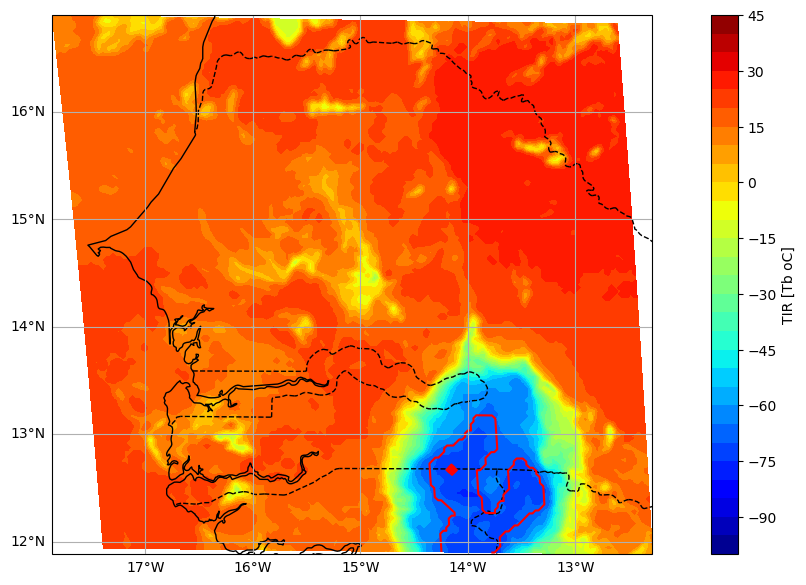

In [10]:
day = 96*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [45]:
# input data- cores_t_0: 
# starting at 
num_frames= 1#8  # previous 2 hours of images to predict 1 hr later
t0= 0#1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
print(np.unique(cores_t_plus_xhr))



[0. 1.]


In [46]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(cores_t_plus_xhr.shape)


(11711, 128, 128)
(11711, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


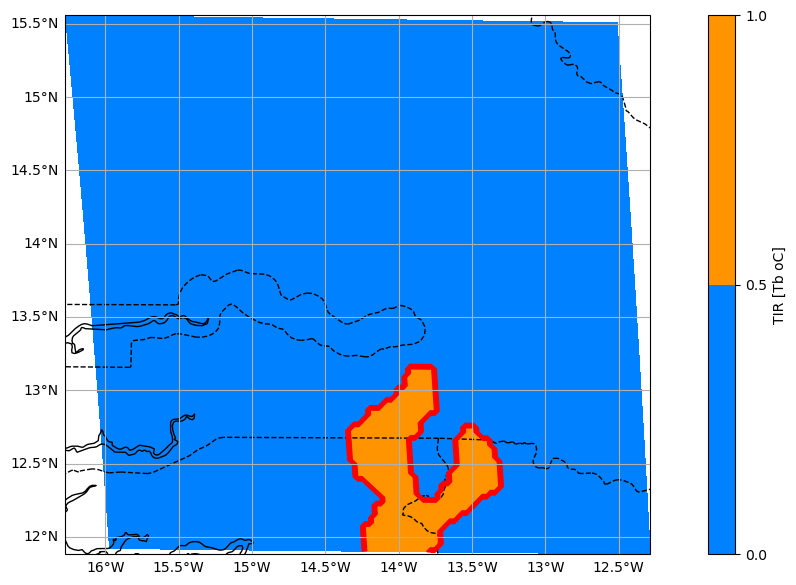

In [47]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores[day,:-a,b:], colors='r')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [15]:
# save variables 
#with open('pkl_files/WA_subdomain_cores_2hr_back.pkl', 'wb') as file: 
  #        pickle.dump([cores_t_0,tir_t_0,cores_t_plus_xhr], file) 
        

In [16]:
# open a file, where you stored the pickled data
#file = open('WA_subdomain_cores.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#cores_t_plus_xhr= data[2]

In [48]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 1 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [49]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=8, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [50]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 128, 128,   0         
                             1)]                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, 128, 128, 8  7232      
                             )                                   
                                                                 
 batch_normalization_2 (Batc  (None, None, 128, 128, 8  32       
 hNormalization)             )                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 128, 128, 8  4640      
                             )                                   
                                                                 
 batch_normalization_3 (Batc  (None, None, 128, 128, 8  32 

In [53]:
num_frames= 8   #24  # hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 50
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0] = cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]

           
# normalize input data        
x_train = x_train/np.max(x_train)
x_val = x_val/np.max(x_train)


In [54]:
print(x_train.shape)
print(x_val.shape)
#batch_size-val_samples
#batch_size

(1413, 8, 128, 128, 1)
(50, 8, 128, 128, 1)


In [55]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 3 # 20
batch_size = 8 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

2023-11-23 22:05:49.683300: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 740818944 exceeds 10% of free system memory.


Epoch 1/3
177/177 [==============================] - 438s 2s/step - loss: 0.1384 - val_loss: 0.1033 - lr: 0.0010
Epoch 2/3
177/177 [==============================] - 431s 2s/step - loss: 0.0068 - val_loss: 0.0457 - lr: 0.0010
Epoch 3/3
177/177 [==============================] - 431s 2s/step - loss: 0.0047 - val_loss: 0.0105 - lr: 0.0010


In [23]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [24]:
#print(x_val.shape)
#print(predicted_frame.shape)
#print(np.where(all_frames>0.35))

In [89]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
# using x_val for now 
#all_frames=np.zeros((50,image_height,image_width, num_channels))

#for b in range(0,51,1):
batch_number = 0 #b #50
frames = x_val[batch_number,0:4,:,:,:] # 
original_frames = x_val[batch_number,4:,:,:,:] # 
#print(frames.shape)
#print(original_frames.shape)
#original_frames = y_val[batch_number,5:,:,:,:] # 
#print(frames.shape)

# Predict a new set of 4 frames.
for _ in range(4):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)
    #all_frames = np.concatenate((all_frames, predicted_frame), axis=0)


(4, 128, 128, 1)
(4, 128, 128, 1)
1/1 [==============================] - 0s 42ms/step


In [90]:
print(frames.shape)
print(original_frames.shape)
#print(new_prediction.shape)
#print(lon[:-a,b:].shape)
#print(lat[:-a,b:].shape)
#ind = np.where(frames[24:,:,:,0]>0.25)
#print((ind))

(8, 128, 128, 1)
(4, 128, 128, 1)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


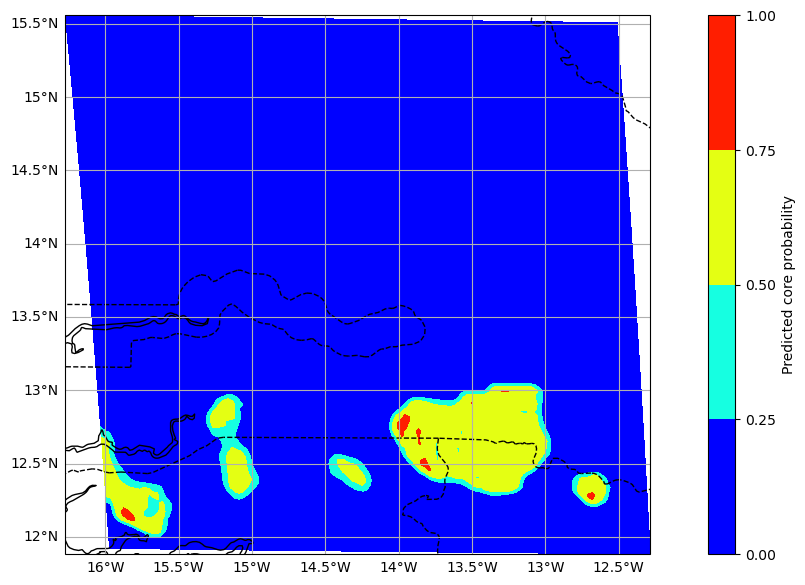

In [91]:
day = 4 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.25,0.5,0.75,1], cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


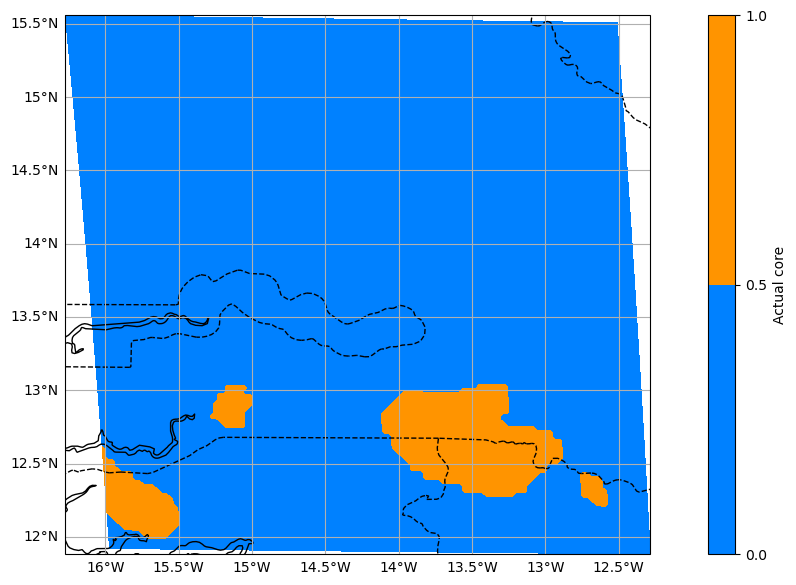

In [92]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[0,:,:,0]), lon[:-a,b:], lat[:-a,b:],levels=[0,0.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

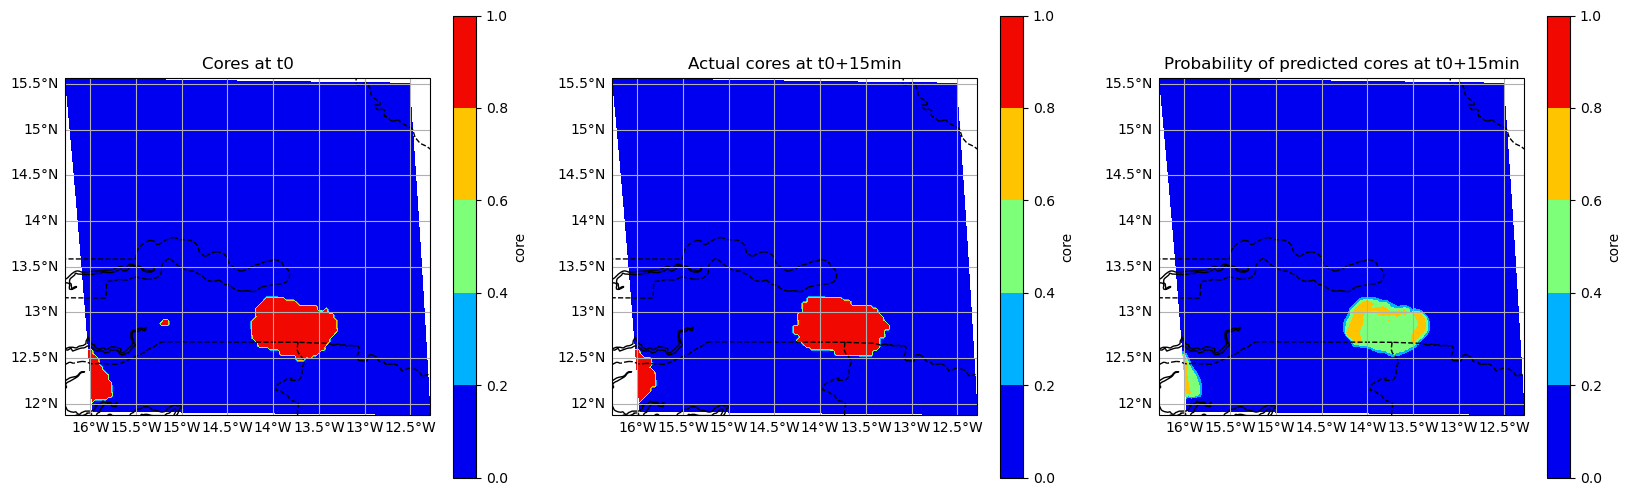

In [73]:
day = 7
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[day,:,:,0])
data[2] = np.squeeze(frames[day+1,:,:,0])
#titles = ['Cores at t0-1hr', 'Cores at t0', 'Probability of cores at t0+1hr']
titles = ['Cores at t0', 'Actual cores at t0+15min', 'Probability of predicted cores at t0+15min']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.3,0.325,0.35,0.4,0.5,0.6]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[0],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [80]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [81]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 15min


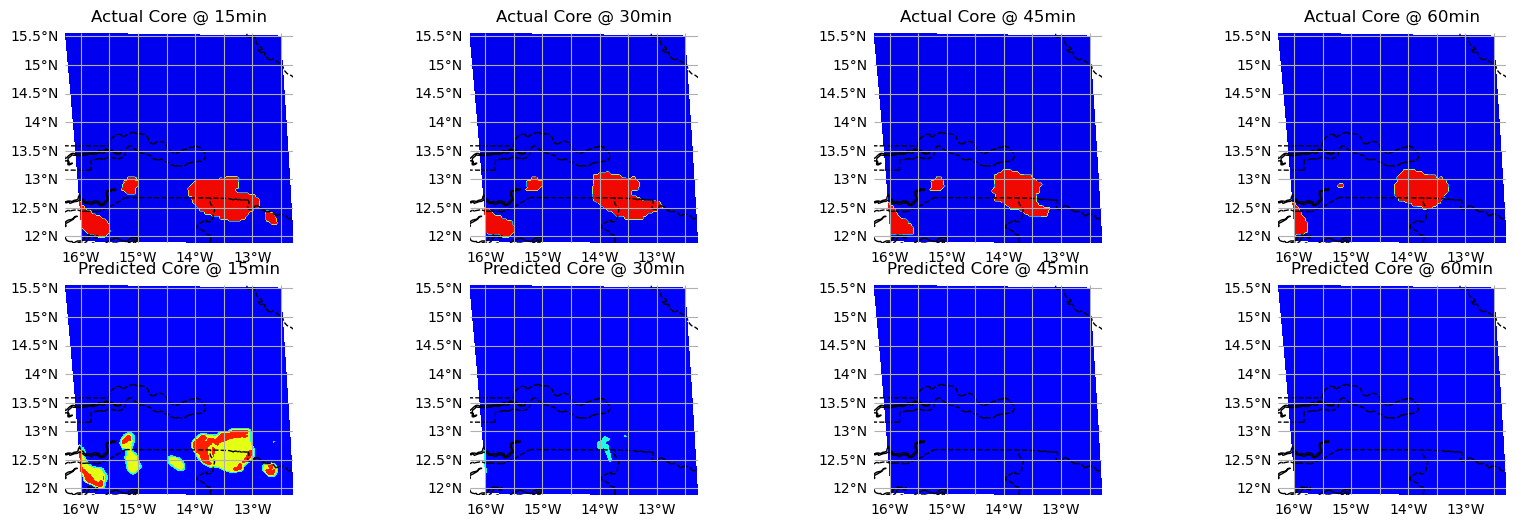

In [99]:
day = 4
data = np.zeros((day,image_height,image_width))
for x in range(0,4,1):
    data[x] = np.squeeze(frames[day+x,:,:,0])
    
    
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1,0.2)]#[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:,0]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx*15 + 15}min")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx*15 + 15}min")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 15min')
plt.show()

In [100]:
# all frames plot

day = 7
data = np.zeros((day+3,image_height,image_width))
for x in range(0,day+1,1):
    data[x] = np.squeeze(frames[x,:,:,0])

data[day+1] = np.squeeze(original_frames[day,:,:,0])
data[day+2] = np.squeeze(frames[day+1,:,:,0])


fig, axes = plt.subplots(1, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})
i=0
for ax in axes:
    plot_maps(lon[:-a,b:], lat[:-a,b:], data[i],  title='Core @ '+str(i),levels_custom= levels_custom[0])
    i=i+1
#fig.savefig('/users/global/jawahm/Documents/Core_forecasting_DL/prediction_frames1.jpg')  
 

fig, axes = plt.subplots(1, 4, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})
for ax in axes:
    plot_maps(lon[:-a,b:], lat[:-a,b:], data[i],  title='Core @ '+str(i),levels_custom= levels_custom[0])
   # draw_map(ax, data[i], lon[:-a,b:], lat[:-a,b:], title='Core @ '+str(i))
    i=i+1
#fig.savefig('/users/global/jawahm/Documents/Core_forecasting_DL/prediction_frames2.jpg')  


titles = ['Actual cores at t0+15min', 'Probability of predicted cores at t0+15min']
#titles = ['Cores at t0-3hr', 'Cores at t0-2hr', 'Cores at t0-1hr']
#titles = ['Cores at t0-6hr', 'Cores at t0-5hr', 'Cores at t0-4hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.3,0.325,0.35,0.4,0.5,0.6]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 2, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})
for ax in axes:
    plot_maps_colorbar(lon[:-a,b:], lat[:-a,b:], data[i],  title=titles[i-day-1],levels_custom= levels_custom[0])
   # draw_map(ax, data[i], lon[:-a,b:], lat[:-a,b:], title='Core @ '+str(i))
    i=i+1

IndexError: index 7 is out of bounds for axis 0 with size 4